In [54]:
#Import libraries 
import praw
import pandas as pd
from datetime import datetime
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns


In [55]:
# Download VADER once 
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/macbook/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [56]:
# Reddit API Credentials
reddit = praw.Reddit(
    client_id="",
    client_secret="",
    user_agent=""
)


In [57]:
# Parameters: post limit and comment number to extract 
subreddits = ['CryptoCurrency', 'Bitcoin', 'Solana']
post_limit = 30
comment_limit = 10

In [58]:
# Helpers: this part add clasification if positive or negative
def get_sentiment_score(text):
    if not text:
        return 0
    return sia.polarity_scores(text)['compound']

def classify_sentiment(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

In [59]:
# Scrape Posts & Comments
posts_data = []

for sub_name in subreddits:
    subreddit = reddit.subreddit(sub_name)
    for post in subreddit.hot(limit=post_limit):
        post.comments.replace_more(limit=0)
        top_comments = [comment.body for comment in post.comments[:comment_limit]]
        joined_comments = " ".join(top_comments)

        post_sentiment_score = get_sentiment_score(post.title + " " + post.selftext)
        comment_sentiment_score = get_sentiment_score(joined_comments)

        post_sentiment_label = classify_sentiment(post_sentiment_score)
        comment_sentiment_label = classify_sentiment(comment_sentiment_score)

        posts_data.append({
            "subreddit": sub_name,
            "title": post.title,
            "text": post.selftext,
            "score": post.score,
            "url": post.url,
            "num_comments": post.num_comments,
            "created": datetime.utcfromtimestamp(post.created_utc).strftime('%Y-%m-%d %H:%M:%S'),
            "top_comments": "\n---\n".join(top_comments),
            "post_sentiment": post_sentiment_score,
            "post_sentiment_label": post_sentiment_label,
            "comment_sentiment": comment_sentiment_score,
            "comment_sentiment_label": comment_sentiment_label
        })

In [60]:
# Save to CSV 
df = pd.DataFrame(posts_data)
df['created'] = pd.to_datetime(df['created'])
df.to_csv("crypto_reddit_sentiment.csv", index=False)
print(f"[+] Saved {len(df)} posts with sentiment analysis and classification to crypto_reddit_sentiment.csv.")

[+] Saved 90 posts with sentiment analysis and classification to crypto_reddit_sentiment.csv.


In [61]:
print(df[['title', 'post_sentiment', 'comment_sentiment']])

                                                title  post_sentiment  \
0     Daily Crypto Discussion - July 27, 2025 (GMT+0)          0.9693   
1                                        Moon Week 64          0.9339   
2   Bitcoin nears $120K as analysis predicts 'larg...          0.0000   
3   BNB hits a new all-time high, briefly topping ...          0.0000   
4                 Her: I like guys who take big risks          0.1027   
..                                                ...             ...   
85  US$500M+ in Real World Assets (RWA) already to...          0.2481   
86  Anza_XYZ - Solana Is Taking Major Steps Toward...          0.9784   
87  Syndica - Deep Dive: Solana DApps Revenue - Ju...          0.9844   
88  I created my first Phantom wallet and I’m wond...          0.2732   
89                             Are we okay here orrr?          0.1280   

    comment_sentiment  
0              0.7138  
1              0.9856  
2              0.8933  
3              0.9530  
4  

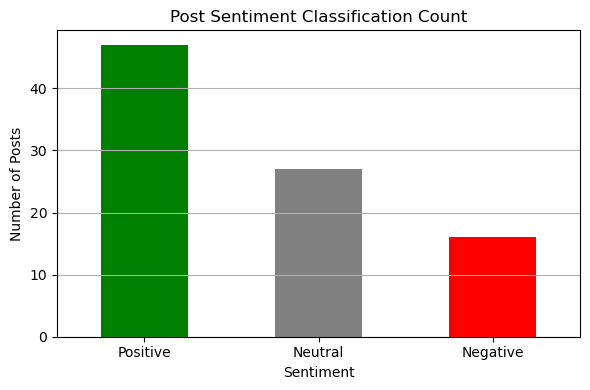

In [62]:
# Visualization Section 

# Sentiment Label Count
label_counts = df['post_sentiment_label'].value_counts()
plt.figure(figsize=(6,4))
label_counts.plot(kind='bar', color=['green', 'gray', 'red'])
plt.title('Post Sentiment Classification Count')
plt.xlabel('Sentiment')
plt.ylabel('Number of Posts')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


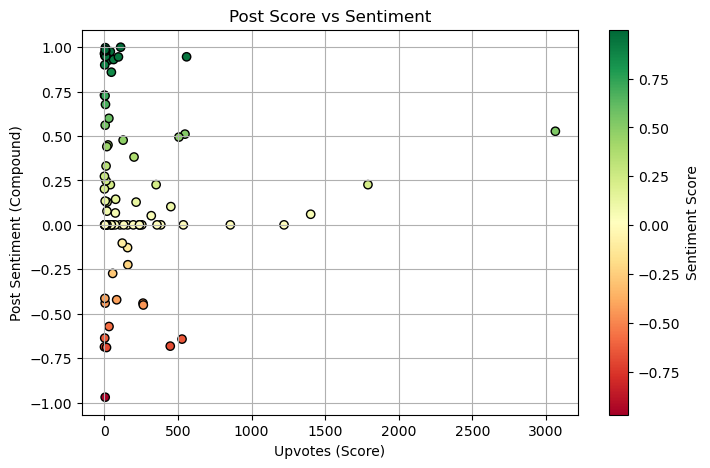

In [63]:
#scatter plot
plt.figure(figsize=(8,5))
plt.scatter(df['score'], df['post_sentiment'], c=df['post_sentiment'], cmap='RdYlGn', edgecolor='k')
plt.colorbar(label='Sentiment Score')
plt.title('Post Score vs Sentiment')
plt.xlabel('Upvotes (Score)')
plt.ylabel('Post Sentiment (Compound)')
plt.grid(True)
plt.show()

In [64]:
df['comment_length'] = df['top_comments'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)


In [65]:
correlation_matrix = df[['score', 'post_sentiment', 'comment_sentiment', 'comment_length']].corr()


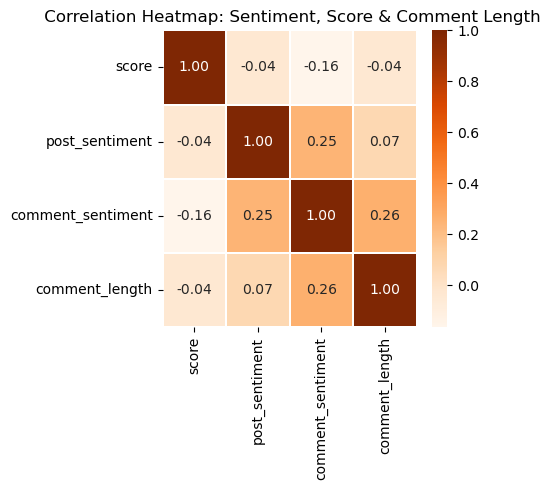

In [69]:
#Heatmap

plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='Oranges', fmt=".2f", linewidths=0.3)
plt.title(' Correlation Heatmap: Sentiment, Score & Comment Length')
plt.tight_layout()
plt.show()
